In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2:
        return max(-(np.log(np.abs(x) -2) - 1), 0)
    elif x > 2:
        return min((np.log(np.abs(x) -2) - 1), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods)
    data['std'] = data['roc'].ewm(span=200).std()
    data['roc_normalized'] = data['roc'] / data['std']
    #data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
sym = 'GC'
start_date='20180901'
inds = {
    #'bollir': run(sym, bolli_reduced, start_date=start_date), 
    'ema': run(sym, ema, start_date=start_date), 
    'breakout': run(sym, breakout, start_date=start_date),
    #'carver': run(sym, carver, adjustment=40, start_date=start_date),
    #'roc': run(sym, roc, start_date=start_date)
}
weights = {
    'bollir': .5, 
    'ema': .2, 
    'breakout': .1,
    'carver': .1,
    'roc': .1,
}

In [10]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
ema,8.57261,6.03318
breakout,8.40269,6.28182


In [11]:
pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()

,ema,breakout
ema,1.000000,0.716448
breakout,0.716448,1.000000


In [12]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()})
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df

In [13]:
data=combine(inds, )

In [14]:
data.forecast.abs().mean(), data.forecast.abs().std()

(7.866563451793159, 5.673847430371232)

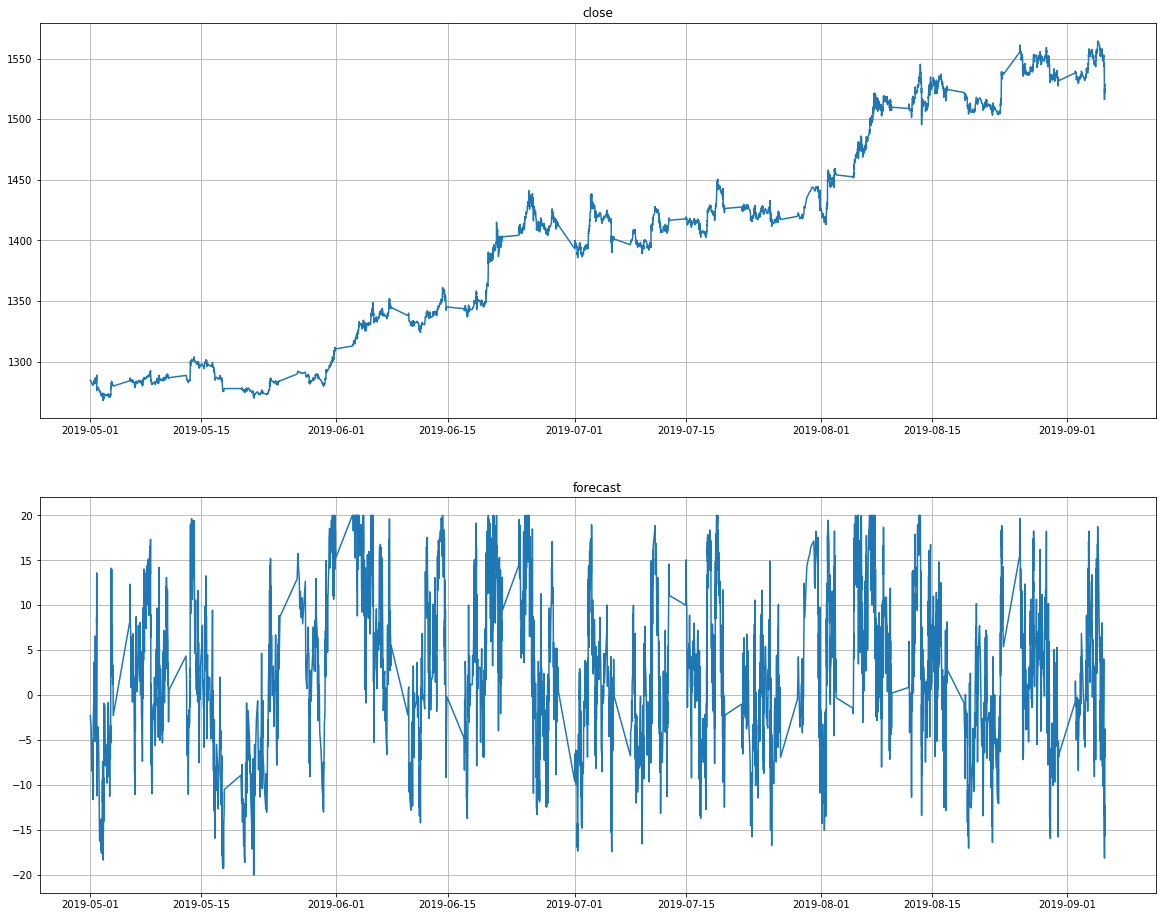

In [15]:
plot(data[['close', 'forecast']])

In [16]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.0271038,0.0137605,0.139911,0.156702,0.256702,0.345277,0.194753,0.0852421,0.0381816
Cumulative returns,0.00991832,0.0050564,0.0495138,0.0551925,0.0879813,0.115675,0.0678724,0.0306496,0.0139245
Annual volatility,0.152728,0.124957,0.107506,0.101735,0.100751,0.0797564,0.0528325,0.0434968,0.0343156
Sharpe ratio,0.25046,0.170909,1.27129,1.48136,2.31847,3.76027,3.39522,1.90243,1.10892
Calmar ratio,0.368103,0.15739,3.87651,4.36011,10.9934,25.8054,19.4657,6.84555,2.5637
Stability,0.223898,0.00561584,0.659299,0.715228,0.879439,0.969073,0.936374,0.770218,0.574619
Max drawdown,-0.0736312,-0.0874293,-0.0360921,-0.0359399,-0.0233506,-0.01338,-0.010005,-0.0124522,-0.0148932
Omega ratio,1.04241,1.0301,1.25302,1.29349,1.5001,2.0543,2.21136,1.56027,1.51335
Sortino ratio,0.379095,0.281519,2.30517,2.85149,4.72181,8.62117,7.79588,3.80681,2.54038
Skew,0.401489,0.849578,1.06603,1.15232,1.04911,1.07571,1.50512,1.33575,3.30276


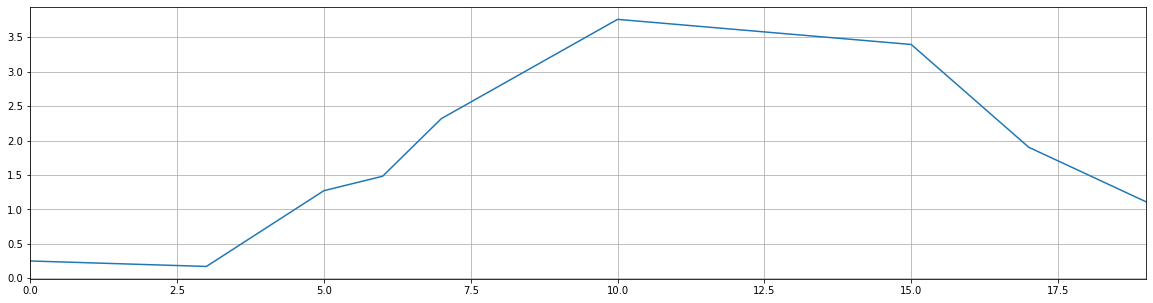

In [17]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [18]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.826757,0.753246,0.750032,0.744601,0.642387,0.406606,0.278730,0.235083
3,0.826757,1.000000,0.903858,0.874851,0.867721,0.761729,0.480279,0.336444,0.223745
5,0.753246,0.903858,1.000000,0.934026,0.896851,0.749925,0.503542,0.340575,0.220914
6,0.750032,0.874851,0.934026,1.000000,0.954032,0.805245,0.550584,0.381201,0.260166
7,0.744601,0.867721,0.896851,0.954032,1.000000,0.853005,0.545853,0.363404,0.229483
10,0.642387,0.761729,0.749925,0.805245,0.853005,1.000000,0.683819,0.523894,0.316459
15,0.406606,0.480279,0.503542,0.550584,0.545853,0.683819,1.000000,0.811675,0.626650
17,0.278730,0.336444,0.340575,0.381201,0.363404,0.523894,0.811675,1.000000,0.696716
19,0.235083,0.223745,0.220914,0.260166,0.229483,0.316459,0.626650,0.696716,1.000000


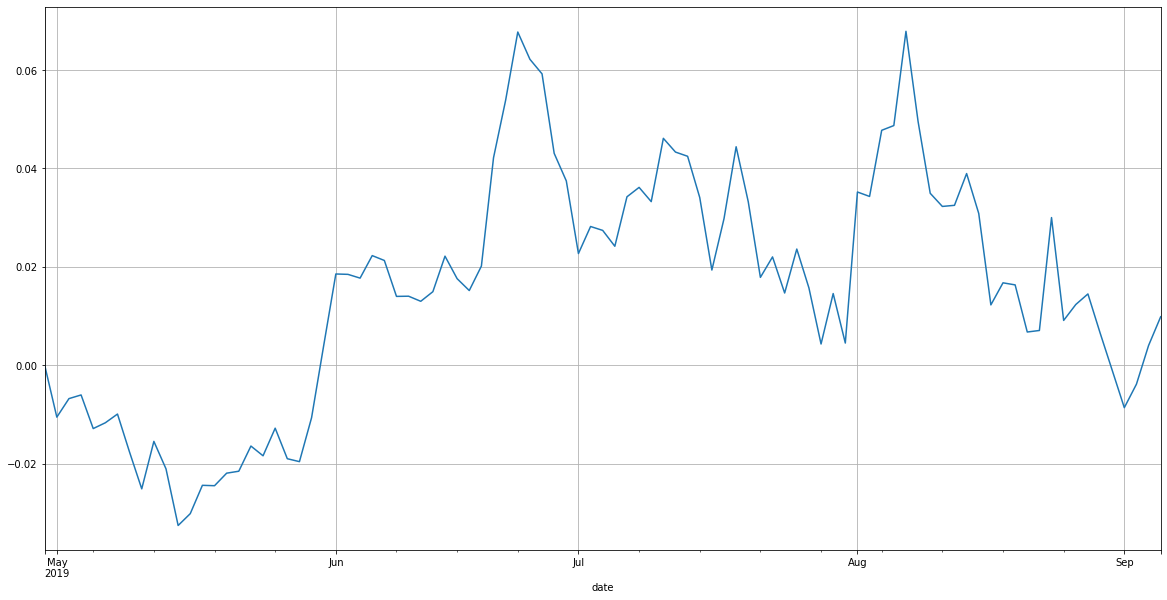

In [19]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

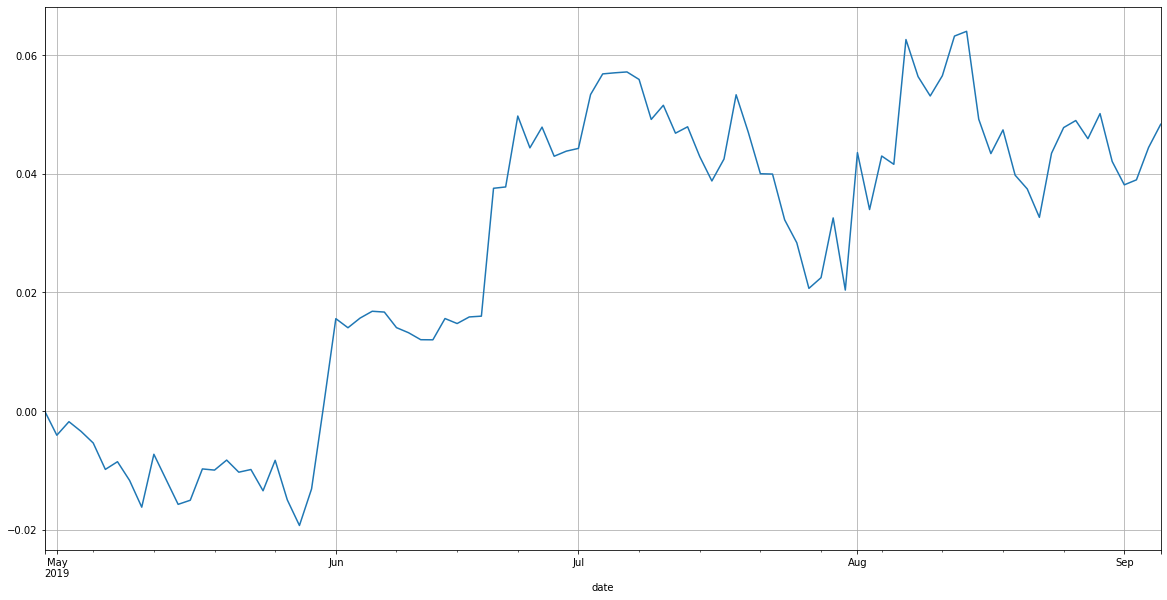

In [20]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

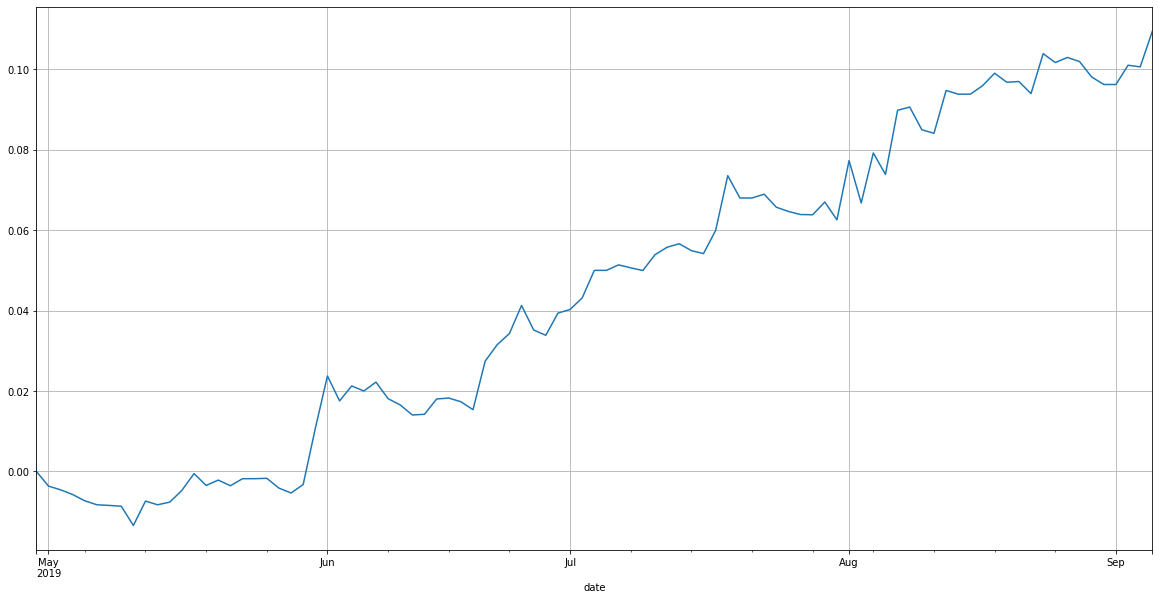

In [21]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);